In [3]:
from triple_stream_data_utils import *


In [2]:
# LOAD DATASETS
import os, pickle, bz2

data_dir = "data/triple_streams/split_2bars/lmd" # "data/triple_streams/split_2bars/lmd or rest"

# find all .pkl.bz2 files in the directory
dataset_pkls = [f for f in os.listdir(data_dir) if f.endswith('.pkl.bz2')]

pkl_fnames = []
for dataset_pkl_fname in dataset_pkls:
    if dataset_pkl_fname.endswith(".pkl.bz2") and dataset_pkl_fname.split(".")[0].split("_")[0] not in pkl_fnames:
        pkl_fnames.append(dataset_pkl_fname.split(".")[0].split("_")[0])
final_dict_fname = "_".join(pkl_fnames) + ".pkl.bz2"
final_dict_fname
# dataset_pkls = ['groove_midi.pkl.bz2']

'lmd.pkl.bz2'

In [ ]:

# print the structure of each dataset
print_all_datasets_structure(data_dir, dataset_pkls)

# load all loops from all datasets
split_n_bar_phrases_unpermutated_outputstreams = get_split_n_bar_phrases(dataset_pkls, data_dir)

# print the number of phrases loaded
print(f"Number of split_n_bar_phrases_unpermutated_outputstreams loaded: {len(split_n_bar_phrases_unpermutated_outputstreams)}")


# INSPECT SOME HVO SAMPLES
# create_multitab_from_HVO_Sequences(split_n_bar_phrases_unpermutated_outputstreams[2000:2010], show_tabs=True)

Dataset Structure for Dataset: lmd_batch_38.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['e8cfbcacff62ff0846427ae3eb82a409', 'f2c07e6b2cbada38d984878eeae9a6c0', 'db6ed95f19464a73c96585c4f12515c7', '165107d946f1190f781db6935c44e48d', 'd93acc17adb91343c842aae7b4b7efef', 'bb91f7ae1c0b9a73eab6a1de62a5111b', '01c4be2d928a6078b7f4ab8f6ebc1504', '15a13b23b94beef08684f7e2c5bc7b65', 'd4cc6be61851fae24579341e2a101417', '3dd754738a74c8e3c7fd91dcbb2b045b']
----------------------------------------
Third Level Keys:
{'hvo_sequences', 'compiled_single_hvos', 'split_n_bar_phrases', 'filenames'}
----------------------------------------


Dataset Structure for Dataset: lmd_batch_28.pkl.bz2
----------------------------------------
First Level Keys:
{'AllAvailableStreams'}
----------------------------------------
Second Level Keys:
['90ddf8f555762d943e10bc97a0da2337', '987eef1c0ef0a67a964734ec329d2fa

In [43]:

accent_v_thresh = 0.6

# Extract control features for all samples
dataset = {
    "input_hvos": [],    #  added √
    "output_hvos": [],   #  added √
    "flat_out_hvos": [], # added √
    # "full_hvo_sequences": [],
    "sample_id": [],        # added √
    "collection": [],       # added √
    "all_metadata": [],     # added √
    "qpm": [],              # added √
    "OF_Input Hamming": [],     # output flattened to input hamming distance         # added √
    "OF_Input Hamming Accent": [],       # added √
    "OS1_OF Jaccard": [],  # Stream 1 of Output's jaccard distance to flattened input       # added √
    "OS2_OF Jaccard": [],  # Stream 2 of Output's jaccard distance to flattened input       # added √
    "OS3_OF Jaccard": [],  # Stream 3 of Output's jaccard distance to flattened input       # added √
}

def mix_streams_into_hvo(streams_list):
    n_streams = len(streams_list)
    n_steps = streams_list[0].shape[0]
    temp_hvo = np.zeros((n_steps, n_streams * 3), dtype=np.float32)
    for i, stream in enumerate(streams_list):
        temp_hvo[:, i] = stream[:, 0]
        temp_hvo[:, i + n_streams] = stream[:, 1]
        temp_hvo[:, i + n_streams * 2] = stream[:, 2]
    return temp_hvo

for hvo_sample in tqdm.tqdm(split_n_bar_phrases_unpermutated_outputstreams):
    for groove_dim in range(4):
        # get info
        sample_id = hvo_sample.metadata["sample_id"]
        collection = hvo_sample.metadata["collection"]
        tempo = hvo_sample.tempos[0].qpm
        all_metadata = hvo_sample.metadata

        # get num of time steps
        t_steps = hvo_sample.hits.shape[0]

        # get groove and outputs
        input_hvo, streams, flat_out_hvo = get_split_to_streams(hvo_sample, groove_dim=groove_dim)

        i_fo_hamming = np.round(hamming_distance(input_hvo[:, 0], flat_out_hvo[:, 0]), 6)
        i_fo_accent_hamming = np.round(hamming_distance(
            get_accent_hits_from_velocities(input_hvo[:, 1], accent_thresh=accent_v_thresh),
            get_accent_hits_from_velocities(flat_out_hvo[:, 1], accent_thresh=accent_v_thresh),
        ), 6)

        for streams_permuation in list_permutations(streams):
            dataset["sample_id"].append(hvo_sample.metadata['sample_id'])
            dataset["collection"].append(hvo_sample.metadata['collection'])
            dataset["all_metadata"].append(hvo_sample.metadata)
            dataset["qpm"].append(tempo)
            dataset["input_hvos"].append(input_hvo)
            dataset["flat_out_hvos"].append(flat_out_hvo)
            dataset["output_hvos"].append(mix_streams_into_hvo(streams_permuation))
            dataset["OF_Input Hamming"].append(i_fo_hamming)
            dataset["OF_Input Hamming Accent"].append(i_fo_accent_hamming)
            dataset["OS1_OF Jaccard"].append(np.round(Jaccard_similarity(flat_out_hvo[:, 0], streams_permuation[0][:, 0]), 6))
            dataset["OS2_OF Jaccard"].append(np.round(Jaccard_similarity(flat_out_hvo[:, 0], streams_permuation[1][:, 0]), 6))
            dataset["OS3_OF Jaccard"].append(np.round(Jaccard_similarity(flat_out_hvo[:, 0], streams_permuation[2][:, 0]), 6))


 50%|█████     | 41446/82687 [00:45<00:45, 908.95it/s]/Users/bezha/PycharmProjects/TripleStreams/triple_stream_data_utils.py:343: RuntimeWarning: invalid value encountered in scalar divide
  
100%|██████████| 82687/82687 [01:31<00:00, 906.12it/s]


In [1]:
# save dictionary in data_dir. use all the names dataset_pkls
pkl_fnames = []
for dataset_pkl_fname in dataset_pkls:
    if dataset_pkl_fname.endswith(".pkl.bz2") and dataset_pkl_fname.split(".")[0].split("_")[0] not in pkl_fnames:
        pkl_fnames.append(dataset_pkl_fname.split(".")[0].split("_")[0])
final_dict_fname = "_".join(pkl_fnames) + ".pkl.bz2"

import pickle, bz2

# dump dataset dict
save_path = os.path.join("data/triple_streams/split_2bars", final_dict_fname)
with bz2.BZ2File(save_path, 'wb') as f:
    pickle.dump(dataset, f)

print(f"Saved dataset dictionary to: {save_path}")


NameError: name 'dataset_pkls' is not defined

In [44]:

sample_ix = 5000 # for each sample 24 variations
input_hvos = dataset["input_hvos"][sample_ix*24: ((sample_ix+1)*24)]
output_hvos = dataset["output_hvos"][sample_ix*24: ((sample_ix+1)*24)]
metadatas = dataset["all_metadata"][sample_ix*24: ((sample_ix+1)*24)]
print(len(input_hvos), len(output_hvos), len(metadatas))
print(dataset["OF_Input Hamming"][sample_ix*24: ((sample_ix+1)*24)])
print(dataset["OF_Input Hamming Accent"][sample_ix*24: ((sample_ix+1)*24)])
print(dataset["OS1_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
print(dataset["OS2_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
print(dataset["OS3_OF Jaccard"][sample_ix*24: ((sample_ix+1)*24)])
create_multitab_from_HVO_Sequences(compile_into_list_of_hvo_seqs(input_hvos, output_hvos, metadatas, qpms=None))


24 24 24
[0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 0.1875, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.3125, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
[0.0, 0.0, 0.6875, 0.6875, 1.0, 1.0, 0.8125, 0.8125, 0.6875, 0.6875, 1.0, 1.0, 0.8125, 0.8125, 0.0, 0.0, 1.0, 1.0, 0.8125, 0.8125, 0.0, 0.0, 0.6875, 0.6875]
[0.6875, 1.0, 0.0, 1.0, 0.0, 0.6875, 0.6875, 1.0, 0.8125, 1.0, 0.8125, 0.6875, 0.0, 1.0, 0.8125, 1.0, 0.8125, 0.0, 0.0, 0.6875, 0.8125, 0.6875, 0.8125, 0.0]
[1.0, 0.6875, 1.0, 0.0, 0.6875, 0.0, 1.0, 0.6875, 1.0, 0.8125, 0.6875, 0.8125, 1.0, 0.0, 1.0, 0.8125, 0.0, 0.8125, 0.6875, 0.0, 0.6875, 0.8125, 0.0, 0.8125]


Loading BokehJS ...

Tabs(id='91265', ...)

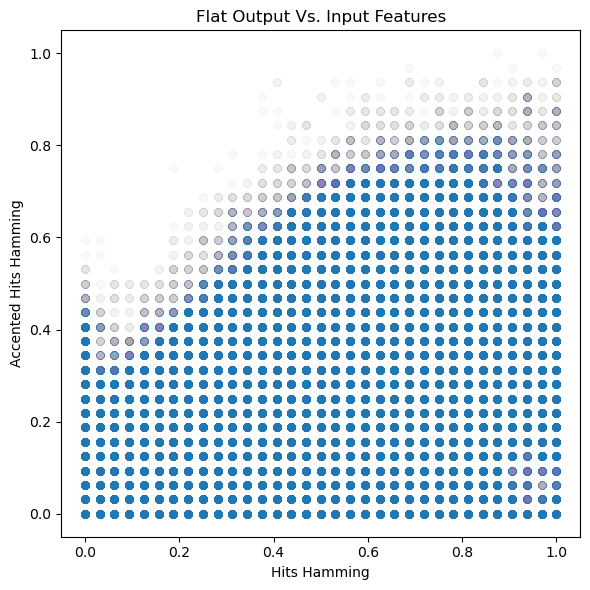

In [45]:
# plot input features
def plot_scatter_distribution(feat1, feat2, xlabel, ylabel, title=None, alpha=0.005, figsize=(6, 6),
                              xlim=(-.05, 1.05), ylim=(-.05, 1.05)):
    if not HAS_MATPLOT: return
    plt.figure(figsize=figsize)
    x = feat1
    y = feat2
    plt.scatter(x, y, alpha=alpha)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if title is not None:
        plt.title(title)
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.tight_layout()
    plt.show()


plot_scatter_distribution(
    feat1=dataset["OF_Input Hamming"],
    feat2=dataset["OF_Input Hamming Accent"],
    xlabel="Hits Hamming",
    ylabel="Accented Hits Hamming",
    title="Flat Output Vs. Input Features"
)

In [18]:
import numpy as np
# box plot import

n_bins = 10
valid_values = np.linspace(0, 1, n_bins)
# get unique hit hamming distances
hit_hamming_values = sorted(set(control_features_df["groove_to_output_hit_hamming_distance"].values))

accent_hamming_values_per_hit_hamming = {float(hit_hamming_value): [] for hit_hamming_value in hit_hamming_values}
for key in accent_hamming_values_per_hit_hamming.keys():
    accent_hamming_values_per_hit_hamming[key] = control_features_df[control_features_df["groove_to_output_hit_hamming_distance"] == key].groove_to_output_accent_hamming_distance.values
    # get box plot stats
    lower_bound = np.sort(accent_hamming_values_per_hit_hamming[key])[10]
    upper_bound = min(np.sort(accent_hamming_values_per_hit_hamming[key])[-20], 1.0)  # upper bound is the 20th largest value or 1.0

    if "accent_hamming_values_per_hit_hamming_normalized" not in control_features_df.columns:
        control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = np.nan

    # strech so that lower bound is 0 and upper bound is 1, then clip to 0-1 range
    if lower_bound < 0.1:
        lower_bound = 0.
    control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "accent_hamming_values_per_hit_hamming_normalized"] = \
        np.clip((control_features_df.loc[control_features_df["groove_to_output_hit_hamming_distance"] == key, "groove_to_output_accent_hamming_distance"] - lower_bound) / (upper_bound - lower_bound), 0, 1)

# change normalized values to the closest valid value
control_features_df["accent_hamming_values_per_hit_hamming_normalized"] = control_features_df["accent_hamming_values_per_hit_hamming_normalized"].apply(
    lambda x: valid_values[np.argmin(np.abs(valid_values - x))] if not np.isnan(x) else np.nan)
# print the first 10 rows of the control features DataFrame

# print new normalized column, vs original
control_features_df[["groove_to_output_hit_hamming_distance", "groove_to_output_accent_hamming_distance", "accent_hamming_values_per_hit_hamming_normalized"]].head(10)


,groove_to_output_hit_hamming_distance,groove_to_output_accent_hamming_distance,accent_hamming_values_per_hit_hamming_normalized
0,0.21875,0.000,0.000000
1,0.21875,0.000,0.000000
2,0.09375,0.000,0.000000
3,0.00000,0.000,0.000000
4,0.21875,0.000,0.000000
5,0.00000,0.000,0.000000
6,0.40625,0.125,0.222222
7,0.34375,0.125,0.222222
8,0.31250,0.125,0.222222
9,0.15625,0.125,0.333333


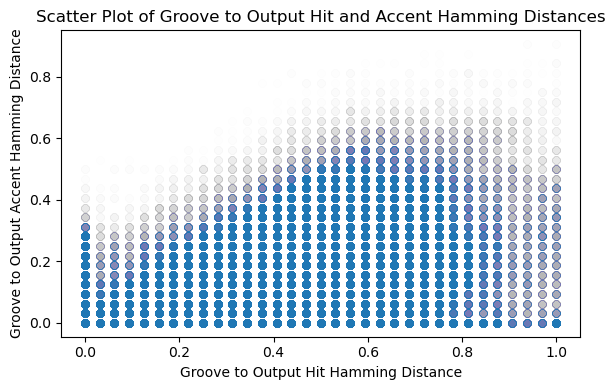

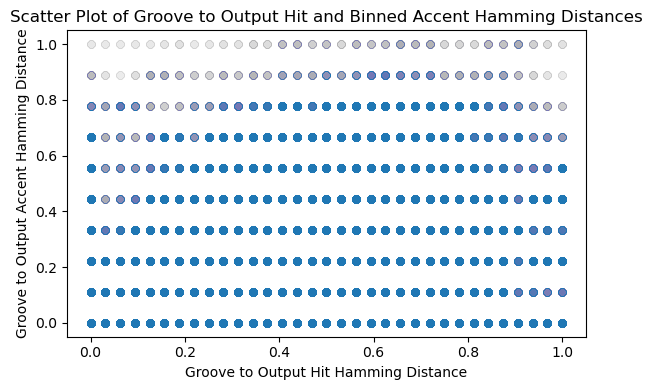

In [19]:
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=False)
plot_scatter_input_output_distribution(control_features_df, use_normalized_accents=True)

Available collections: ['groove_midi']


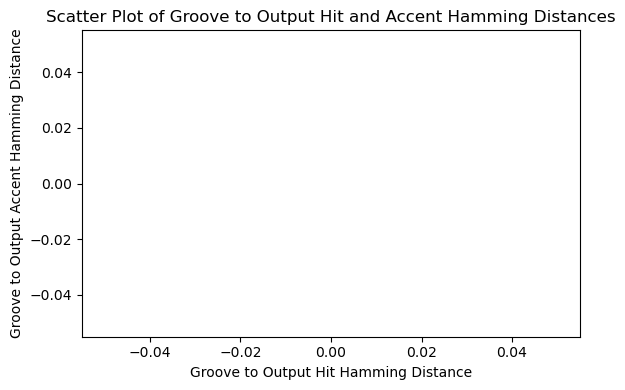

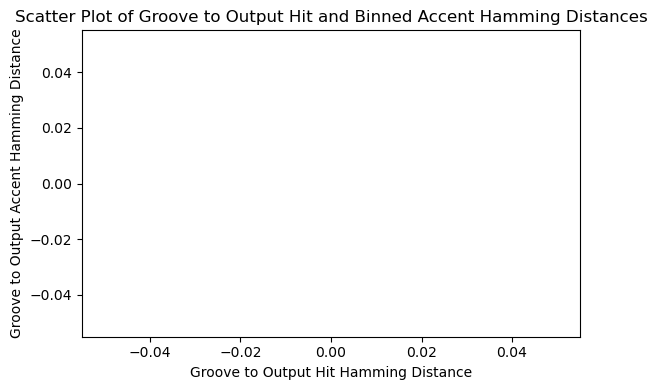

In [20]:

# get all available collections
collections = control_features_df["collection"].unique()
print(f"Available collections: {collections}")
# exclude groove_midi
df_subset = control_features_df[control_features_df["collection"] == "lmd_batch_60"]
plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
df_subset = control_features_df[control_features_df["collection"] == "lmd_batch_60"]
plot_scatter_input_output_distribution(df_subset, use_normalized_accents=True)
# df_subset = control_features_df[control_features_df["collection"] == "elbg"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "candombe"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "taptamdrum_hvo_output_both_is_and"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)
# df_subset = control_features_df[control_features_df["collection"] == "groove_midi"]
# plot_scatter_input_output_distribution(df_subset, use_normalized_accents=False)


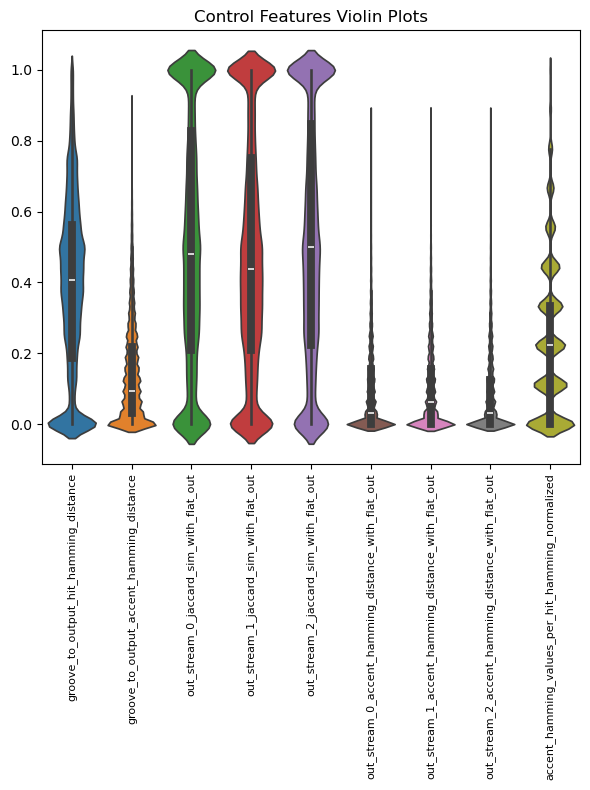

In [21]:
plot_control_features_violin(control_features_df)


In [22]:
# plot histogram of Accent hamming for hit distance of n (actual distance will be n*1./31.)
def plot_histogram_accent_hamming_distance(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    plt.figure(figsize=(6, 4))
    hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
    accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

    plt.hist(accent_hamming_distance[hit_hamming_distance == hit_hamming_distance_index/32.0], bins=30, alpha=0.7)
    plt.xlabel("Accent Hamming Distance")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of Accent Hamming Distance for Hit Distance {hit_hamming_distance_index}")
    plt.tight_layout()
    plt.show()

# create a grid of 4 x 8 figures with the histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
def plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=0):
    """
    Plot histogram of accent hamming distance for hit distance of n (actual distance will be n*1./32.)
    :param control_features_df: pd.DataFrame
        DataFrame containing the control features.
    :param hit_hamming_distance_index: int
        The index of the hit hamming distance to plot.
    """
    fig, axs = plt.subplots(4, 8, figsize=(16, 8))
    axs = axs.flatten()

    for i in range(32):
        hit_hamming_distance = control_features_df["groove_to_output_hit_hamming_distance"]
        accent_hamming_distance = control_features_df["groove_to_output_accent_hamming_distance"]

        axs[i].hist(accent_hamming_distance[hit_hamming_distance == i/32.0], bins=30, alpha=0.7)
        axs[i].set_xlabel("Accent Hamming Distance")
        axs[i].set_ylabel("Frequency")
        axs[i].set_title(f"Hit Distance {i}")

    plt.tight_layout()
    plt.show()

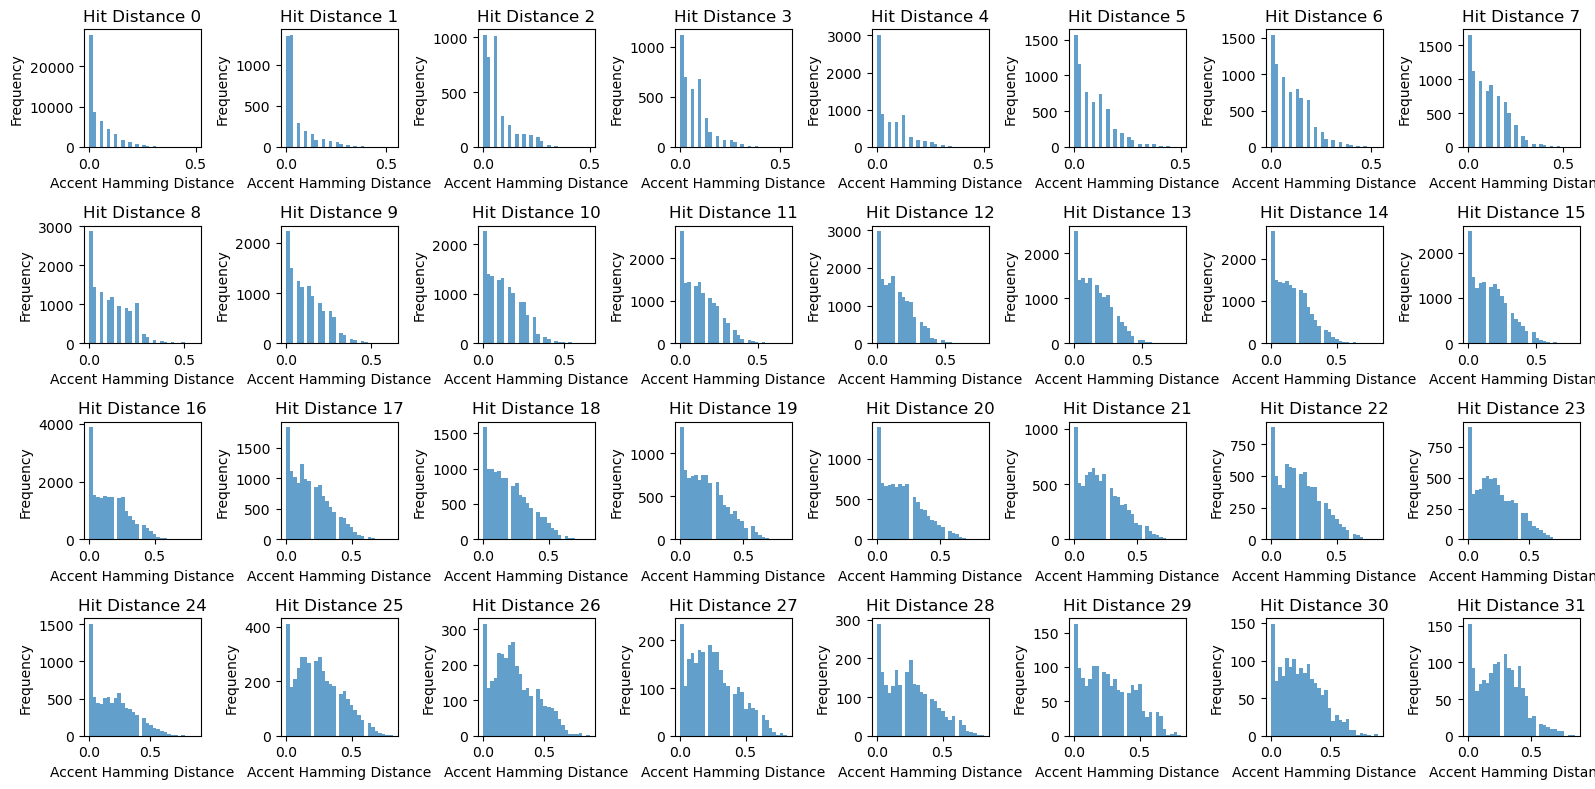

In [23]:

plot_histogram_accent_hamming_distance_grid(control_features_df, hit_hamming_distance_index=32)


In [24]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import numpy as np

def create_heatmap_histogram(df, key1, key2, bins=None, title=None, exclude_pairs=None,
                           show_zeros=False):
    """
    Creates an interactive heatmap histogram from a DataFrame using two keys.
    Shows frequency counts in each cell like a confusion matrix.

    Parameters:
    -----------
    df : pandas.DataFrame
        The input dataframe
    key1 : str
        Column name for x-axis
    key2 : str
        Column name for y-axis
    bins : int, tuple, or None, optional
        Number of bins for each dimension. If None (default), uses all unique values
    title : str, optional
        Plot title (default: auto-generated)
    exclude_pairs : list of tuples or tuple, optional
        Specific (key1, key2) value pairs to exclude from calculations
        e.g., [(10, 20), (15, 25)] or (10, 20) for single exclusion
    show_zeros : bool, optional
        Whether to show 0 counts in cells (default: False)

    Returns:
    --------
    plotly.graph_objects.Figure
        Interactive heatmap with counts
    """

    # Create a copy to avoid modifying original dataframe
    df_filtered = df.copy()

    # Handle exclusions
    if exclude_pairs is not None:
        # Convert single tuple to list of tuples
        if isinstance(exclude_pairs, tuple):
            exclude_pairs = [exclude_pairs]

        # Create boolean mask for rows to keep
        mask = pd.Series([True] * len(df_filtered), index=df_filtered.index)

        for pair in exclude_pairs:
            if len(pair) != 2:
                raise ValueError("Each exclusion pair must contain exactly 2 values")

            exclude_mask = (df_filtered[key1] == pair[0]) & (df_filtered[key2] == pair[1])
            mask = mask & ~exclude_mask

            # Print info about excluded points
            excluded_count = exclude_mask.sum()
            if excluded_count > 0:
                print(f"Excluded {excluded_count} points with ({key1}={pair[0]}, {key2}={pair[1]})")

        # Apply the mask
        df_filtered = df_filtered[mask]
        print(f"Total rows after exclusions: {len(df_filtered)} (original: {len(df)})")

    # Extract data for the two keys and remove NaN values
    valid_data = df_filtered[[key1, key2]].dropna()
    x_data = valid_data[key1]
    y_data = valid_data[key2]

    if len(x_data) == 0:
        print("Warning: No valid data points remaining after exclusions and NaN removal")
        return None

    # Handle bins=None case (use unique values)
    if bins is None:
        # Create cross-tabulation using unique values
        crosstab = pd.crosstab(y_data, x_data, dropna=False)

        # Get sorted unique values for consistent ordering
        x_values = sorted(x_data.unique())
        y_values = sorted(y_data.unique())

        # Reindex to ensure all values are present
        crosstab = crosstab.reindex(index=y_values, columns=x_values, fill_value=0)

        # Create labels (convert to string for display)
        x_labels = [str(x) for x in x_values]
        y_labels = [str(y) for y in y_values]

        # Get the count matrix
        count_matrix = crosstab.values

    else:
        # Use binning approach for numeric bins
        # Create 2D histogram using numpy
        hist, x_edges, y_edges = np.histogram2d(x_data, y_data, bins=bins)

        # Create bin labels for better readability
        x_labels = []
        for i in range(len(x_edges) - 1):
            x_labels.append(f"{x_edges[i]:.1f}-{x_edges[i+1]:.1f}")

        y_labels = []
        for i in range(len(y_edges) - 1):
            y_labels.append(f"{y_edges[i]:.1f}-{y_edges[i+1]:.1f}")

        # Transpose histogram for correct orientation
        count_matrix = hist.T

    # Create text annotations for each cell (showing the count)
    text_annotations = []
    for i in range(len(y_labels)):
        row = []
        for j in range(len(x_labels)):
            count = int(count_matrix[i, j])
            if count > 0 or show_zeros:
                row.append(str(count))
            else:
                row.append("")  # Don't show 0s for cleaner look unless requested
        text_annotations.append(row)

    # Create the heatmap
    fig = go.Figure(data=go.Heatmap(
        z=count_matrix,
        x=x_labels,
        y=y_labels,
        text=text_annotations,
        texttemplate="%{text}",
        textfont={"size": max(8, min(12, 300 // max(len(x_labels), len(y_labels))))},  # Dynamic font size
        colorscale='Plasma', # 'YlGnBu', 'Cividis', 'Plasma', 'Inferno', 'Magma'
        showscale=True,
        colorbar=dict(title="Count"),
        hovertemplate=f'{key1}: %{{x}}<br>{key2}: %{{y}}<br>Count: %{{z}}<extra></extra>'
    ))

    # Update layout
    if title is None:
        exclusion_info = f" (Excluded {len(exclude_pairs)} pairs)" if exclude_pairs else ""
        bins_info = "All unique values" if bins is None else f"{bins} bins"
        title = f'Heatmap: {key1} vs {key2} ({bins_info}){exclusion_info}'

    # Dynamic sizing based on number of categories
    plot_width = max(600, len(x_labels) * 40)
    plot_height = max(400, len(y_labels) * 30)

    fig.update_layout(
        title=title,
        xaxis_title=key1,
        yaxis_title=key2,
        width=min(plot_width, 1200),  # Cap maximum width
        height=min(plot_height, 800), # Cap maximum height
        xaxis=dict(tickangle=45 if len(x_labels) > 10 else 0),
        yaxis=dict(tickangle=0)
    )

    return fig

def create_binned_heatmap_histogram(df, key1, key2, bins=20, title=None, exclude_pairs=None,
                                  show_zeros=False):
    """
    Creates a heatmap for continuous data with explicit binning.
    This is the old behavior when you specifically want to bin continuous data.

    Parameters are the same as create_heatmap_histogram but bins defaults to 20.
    """
    return create_heatmap_histogram(df, key1, key2, bins=bins, title=title,
                                  exclude_pairs=exclude_pairs, show_zeros=show_zeros)

# Helper function to check data characteristics
def analyze_data_for_binning(df, key1, key2):
    """
    Analyzes the data to suggest whether binning might be needed.

    Returns:
    --------
    dict: Information about the data characteristics
    """
    x_data = df[key1].dropna()
    y_data = df[key2].dropna()

    x_unique_count = x_data.nunique()
    y_unique_count = y_data.nunique()

    x_is_numeric = pd.api.types.is_numeric_dtype(x_data)
    y_is_numeric = pd.api.types.is_numeric_dtype(y_data)

    analysis = {
        'x_unique_count': x_unique_count,
        'y_unique_count': y_unique_count,
        'x_is_numeric': x_is_numeric,
        'y_is_numeric': y_is_numeric,
        'total_combinations': x_unique_count * y_unique_count,
        'data_points': len(df[[key1, key2]].dropna())
    }

    # Suggestions
    if analysis['total_combinations'] > 100:
        analysis['suggestion'] = f"Consider using bins (e.g., bins=20) as you have {analysis['total_combinations']} unique combinations"
    elif analysis['total_combinations'] > 50:
        analysis['suggestion'] = "Data might benefit from binning for cleaner visualization"
    else:
        analysis['suggestion'] = "Using unique values (bins=None) should work well"

    return analysis


create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="groove_to_output_accent_hamming_distance",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Accent Hamming Distance",
                         )




In [26]:
create_heatmap_histogram(control_features_df,
                         key1="groove_to_output_hit_hamming_distance",
                         key2="accent_hamming_values_per_hit_hamming_normalized",
                         bins=None,
                         title="Heatmap Histogram of Groove to Output Hit Hamming Distance vs Modified Accent Hamming Distance",
                         )